### transformer breakdown

In [1]:
import torch

/home/kyle/pythonenvs/venv38/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

transformer_model = torch.nn.Transformer(nhead=16, num_encoder_layers=12)

class Net(torch.nn.Module):
    def __init__(self, model):
        super(Net, self).__init__()
        self.model = model
        self.encoder = model.encoder # src, mask, src key padding mask
        self.decoder = model.decoder # tgt, memory, tgt mask, memory mask, tgt key padding mask, memory key padding mask


    def forward(self, src, tgt):
        mem = self.encoder(src) # apply M
        output = self.decoder(tgt, mem)
        
        return output

src = torch.rand((10, 32, 512))
tgt = torch.rand((20, 32, 512))
# oi = transformer_model.encoder(src)
# of = transformer_model.decoder(oi, tgt)
# print(oi.shape)
# print(of.shape)
# o1 = transformer_model(src, tgt)
# net = Net(transformer_model)
# o2 = net(src,tgt)
# print('o1 ', o1.shape)
# print('o2 ', o2.shape)
# print(o1)
# print(o2)

In [3]:
transformer_model.encoder.layers[0]

TransformerEncoderLayer(
  (self_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=512, out_features=512, bias=True)
  )
  (linear1): Linear(in_features=512, out_features=2048, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (linear2): Linear(in_features=2048, out_features=512, bias=True)
  (norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (norm2): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
  (dropout1): Dropout(p=0.1, inplace=False)
  (dropout2): Dropout(p=0.1, inplace=False)
)

### WMT2014 dataset

### pytorch Multi30k tutorial
complete with early stopping and testing with bleu score
only concern is that original transformer arch was not tested on multi30k but on wmt2014 instead

#### setup

try to download a mt dataset, https://pytorch.org/tutorials/beginner/translation_transformer.html

In [4]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from torchtext.datasets import multi30k, Multi30k
from typing import Iterable, List
import torchdata


# We need to modify the URLs for the dataset since the links to the original dataset are broken
# Refer to https://github.com/pytorch/text/issues/1756#issuecomment-1163664163 for more info
multi30k.URL["train"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/training.tar.gz"
multi30k.URL["valid"] = "https://raw.githubusercontent.com/neychev/small_DL_repo/master/datasets/Multi30k/validation.tar.gz"

SRC_LANGUAGE = 'en'
TGT_LANGUAGE = 'de'

# Place-holders
token_transform = {}
vocab_transform = {}


# Create source and target language tokenizer. Make sure to install the dependencies.
# pip install -U torchdata
# pip install -U spacy
# python -m spacy download en_core_web_sm
# python -m spacy download de_core_news_sm
token_transform[SRC_LANGUAGE] = get_tokenizer('spacy', language='de_core_news_sm')
token_transform[TGT_LANGUAGE] = get_tokenizer('spacy', language='en_core_web_sm')


# helper function to yield list of tokens
def yield_tokens(data_iter: Iterable, language: str) -> List[str]:
    language_index = {SRC_LANGUAGE: 0, TGT_LANGUAGE: 1}

    for data_sample in data_iter:
        yield token_transform[language](data_sample[language_index[language]])

# Define special symbols and indices
UNK_IDX, PAD_IDX, BOS_IDX, EOS_IDX = 0, 1, 2, 3
# Make sure the tokens are in order of their indices to properly insert them in vocab
special_symbols = ['<unk>', '<pad>', '<bos>', '<eos>']

for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    # Training data Iterator
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    # Create torchtext's Vocab object
    vocab_transform[ln] = build_vocab_from_iterator(yield_tokens(train_iter, ln),
                                                    min_freq=1,
                                                    specials=special_symbols,
                                                    special_first=True)

# Set UNK_IDX as the default index. This index is returned when the token is not found.
# If not set, it throws RuntimeError when the queried token is not found in the Vocabulary.
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
  vocab_transform[ln].set_default_index(UNK_IDX)

In [5]:
type(vocab_transform)

dict

In [6]:
# BATCH_SIZE = 64

# train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
# train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# ct = 0
# for thing in enumerate(train_dataloader):
#     # print(thing[1][0].shape, thing[1][1].shape)
#     ct +=1 
# NUM_BATCHES = ct
# print(ct)
# # thing
NUM_BATCHES = 454 # for multi30k w bs=64

### model

#### MNet

#### seq2seq transformer arch

In [7]:
from torch import Tensor
import torch
import torch.nn as nn
from torch.nn import Transformer
import math
DEVICE = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

# helper Module that adds positional encoding to the token embedding to introduce a notion of word order.
class PositionalEncoding(nn.Module):
    def __init__(self,
                 emb_size: int,
                 dropout: float,
                 maxlen: int = 5000):
        super(PositionalEncoding, self).__init__()
        den = torch.exp(- torch.arange(0, emb_size, 2)* math.log(10000) / emb_size)
        pos = torch.arange(0, maxlen).reshape(maxlen, 1)
        pos_embedding = torch.zeros((maxlen, emb_size))
        pos_embedding[:, 0::2] = torch.sin(pos * den)
        pos_embedding[:, 1::2] = torch.cos(pos * den)
        pos_embedding = pos_embedding.unsqueeze(-2)

        self.dropout = nn.Dropout(dropout)
        self.register_buffer('pos_embedding', pos_embedding)

    def forward(self, token_embedding: Tensor):
        return self.dropout(token_embedding + self.pos_embedding[:token_embedding.size(0), :])

# helper Module to convert tensor of input indices into corresponding tensor of token embeddings
class TokenEmbedding(nn.Module):
    def __init__(self, vocab_size: int, emb_size):
        super(TokenEmbedding, self).__init__()
        self.embedding = nn.Embedding(vocab_size, emb_size)
        self.emb_size = emb_size

    def forward(self, tokens: Tensor):
        return self.embedding(tokens.long()) * math.sqrt(self.emb_size)

# Seq2Seq Network
class Seq2SeqTransformer(nn.Module):
    def __init__(self,
                 num_encoder_layers: int,
                 num_decoder_layers: int,
                 emb_size: int,
                 nhead: int,
                 src_vocab_size: int,
                 tgt_vocab_size: int,
                 dim_feedforward: int = 512,
                 dropout: float = 0.1):
        super(Seq2SeqTransformer, self).__init__()
        if False:
            self.transformer = CustomTransformer(d_model=emb_size,
                                       nhead=nhead,
                                       num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        else: 
            self.transformer = Transformer(d_model=emb_size,
                                        nhead=nhead,
                                        num_encoder_layers=num_encoder_layers,
                                       num_decoder_layers=num_decoder_layers,
                                       dim_feedforward=dim_feedforward,
                                       dropout=dropout)
        self.generator = nn.Linear(emb_size, tgt_vocab_size)
        self.src_tok_emb = TokenEmbedding(src_vocab_size, emb_size)
        self.tgt_tok_emb = TokenEmbedding(tgt_vocab_size, emb_size) # not returning the attn output weights
        self.positional_encoding = PositionalEncoding(
            emb_size, dropout=dropout)

    def forward(self,
                src: Tensor,
                trg: Tensor,
                src_mask: Tensor,
                tgt_mask: Tensor,
                src_padding_mask: Tensor,
                tgt_padding_mask: Tensor,
                memory_key_padding_mask: Tensor):
        src_emb = self.positional_encoding(self.src_tok_emb(src))
        # print('src_emb.shape ', src_emb.shape)
        # print('src_mask.shape ', src_mask.shape)
        # print('src_emb ', src_emb)
        # print('src_mask ', src_mask)
        # exit(0)
        tgt_emb = self.positional_encoding(self.tgt_tok_emb(trg))
        outs = self.transformer(src_emb, tgt_emb, src_mask, tgt_mask, None,
                                src_padding_mask, tgt_padding_mask, memory_key_padding_mask) # find out how masking is applied within forward method
        return self.generator(outs)

    def encode(self, src: Tensor, src_mask: Tensor):
        return self.transformer.encoder(self.positional_encoding(
                            self.src_tok_emb(src)), src_mask)

    def decode(self, tgt: Tensor, memory: Tensor, tgt_mask: Tensor):
        return self.transformer.decoder(self.positional_encoding(
                          self.tgt_tok_emb(tgt)), memory,
                          tgt_mask)

#### masking

In [8]:
def generate_square_subsequent_mask(sz):
    mask = (torch.triu(torch.ones((sz, sz), device=DEVICE)) == 1).transpose(0, 1)
    mask = mask.float().masked_fill(mask == 0, float('-inf')).masked_fill(mask == 1, float(0.0))
    return mask


def create_mask(src, tgt):
    src_seq_len = src.shape[0]
    tgt_seq_len = tgt.shape[0]

    tgt_mask = generate_square_subsequent_mask(tgt_seq_len)
    src_mask = torch.zeros((src_seq_len, src_seq_len),device=DEVICE).type(torch.bool)

    src_padding_mask = (src == PAD_IDX).transpose(0, 1)
    tgt_padding_mask = (tgt == PAD_IDX).transpose(0, 1)
    return src_mask, tgt_mask, src_padding_mask, tgt_padding_mask

#### training setup

In [9]:
torch.manual_seed(0)

SRC_VOCAB_SIZE = len(vocab_transform[SRC_LANGUAGE])
TGT_VOCAB_SIZE = len(vocab_transform[TGT_LANGUAGE])
EMB_SIZE = 512
NHEAD = 8
FFN_HID_DIM = 2048
BATCH_SIZE = 64
NUM_ENCODER_LAYERS = 6
NUM_DECODER_LAYERS = 6

transformer = Seq2SeqTransformer(NUM_ENCODER_LAYERS, NUM_DECODER_LAYERS, EMB_SIZE,
                                 NHEAD, SRC_VOCAB_SIZE, TGT_VOCAB_SIZE, FFN_HID_DIM)

for p in transformer.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

transformer = transformer.to('cuda:1')

loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX, label_smoothing=0.1)
lr = 0.0007 

optimizer = torch.optim.Adam(transformer.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)
# optimizer = torch.optim.Adam(transformer.transformer.get_parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

#### batching

In [10]:
from torch.nn.utils.rnn import pad_sequence

# helper function to club together sequential operations
def sequential_transforms(*transforms):
    def func(txt_input):
        for transform in transforms:
            txt_input = transform(txt_input)
        return txt_input
    return func

# function to add BOS/EOS and create tensor for input sequence indices
def tensor_transform(token_ids: List[int]):
    return torch.cat((torch.tensor([BOS_IDX]),
                      torch.tensor(token_ids),
                      torch.tensor([EOS_IDX])))

# src and tgt language text transforms to convert raw strings into tensors indices
text_transform = {}
for ln in [SRC_LANGUAGE, TGT_LANGUAGE]:
    text_transform[ln] = sequential_transforms(token_transform[ln], #Tokenization
                                               vocab_transform[ln], #Numericalization
                                               tensor_transform) # Add BOS/EOS and create tensor


# function to collate data samples into batch tensors
def collate_fn(batch):
    src_batch, tgt_batch = [], []
    for src_sample, tgt_sample in batch:
        src_batch.append(text_transform[SRC_LANGUAGE](src_sample.rstrip("\n")))
        tgt_batch.append(text_transform[TGT_LANGUAGE](tgt_sample.rstrip("\n")))

    src_batch = pad_sequence(src_batch, padding_value=PAD_IDX)
    tgt_batch = pad_sequence(tgt_batch, padding_value=PAD_IDX)
    return src_batch, tgt_batch

#### training func

In [11]:
LARGE_BATCH_SIZE = 13

In [12]:
from torch.utils.data import DataLoader
from threading import Thread

class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

def update_lr(step_num):
    num_warmup = 4000
    return (EMB_SIZE)**-0.5 * min(step_num**(-0.5), step_num * num_warmup**(-1.5))

def train_epoch(model, optimizer):
    # print('epoch, ', epoch)
    model.train()
    losses = 0
    saved_losses = []
    train_iter = Multi30k(split='train', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    train_dataloader = DataLoader(train_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    step = 1
    minibatch_counter = 0
    for src, tgt in train_dataloader:
        src = src.to(DEVICE)
        # if src.shape[1] != BATCH_SIZE:
        #     print('not skipping batch of size ',src.shape[1])
        #     # continue 
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        # optimizer.zero_grad()
        step_num = int((epoch-1) * (NUM_BATCHES // LARGE_BATCH_SIZE)) + step # FIXME: is this right?
        # if epoch > 1 and step == 0:
        #     step_num = epoch * NUM_BATCHES
        # optimizer.param_groups[0]['lr'] = update_lr(step_num)
        
        
        # print('updated lr: ', optimizer.param_groups[0]['lr'])

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        loss.backward() # FIXME: does the .backward() continue to accumlate gradient?

        # optimizer.step()
        losses += loss.item()
        saved_losses.append(loss.item())
        # step += 1 # each minibatch of data is considered 1 step  -- false each larger BATCH should be consider one step
        minibatch_counter += 1

        if minibatch_counter > LARGE_BATCH_SIZE - 1: 
            minibatch_counter = 0
            # update the lr and the weights
            # print(step)
            # print((NUM_BATCHES // LARGE_BATCH_SIZE))
            # print(epoch-1)
            # print(int(epoch-1 * (NUM_BATCHES / LARGE_BATCH_SIZE)) + step)
            # print(int((epoch-1) * (NUM_BATCHES / LARGE_BATCH_SIZE)) + 0)
            # print( int(epoch * (NUM_BATCHES / LARGE_BATCH_SIZE)) + step )

            # print(type(step_num))
            # print((step_num))
            optimizer.param_groups[0]['lr'] = update_lr(step_num)
            optimizer.step()
            # reset grad
            optimizer.zero_grad()
            step += 1

        
    # update lr and weights as long as they weren't JUST updated
    if minibatch_counter > 0:
        # update the lr and the weights
        optimizer.param_groups[0]['lr'] = update_lr(step_num)
        optimizer.step()
        # reset grad
        optimizer.zero_grad()
        step += 1

    # step += 1
    return losses / len(list(train_dataloader)), saved_losses

def evaluate(model):
    model.eval()
    losses = 0
    saved_losses_val = []
    val_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    val_dataloader = DataLoader(val_iter, batch_size=BATCH_SIZE, collate_fn=collate_fn)

    for src, tgt in val_dataloader:
        src = src.to(DEVICE)
        tgt = tgt.to(DEVICE)

        tgt_input = tgt[:-1, :]

        src_mask, tgt_mask, src_padding_mask, tgt_padding_mask = create_mask(src, tgt_input)

        logits = model(src, tgt_input, src_mask, tgt_mask,src_padding_mask, tgt_padding_mask, src_padding_mask)

        tgt_out = tgt[1:, :]
        loss = loss_fn(logits.reshape(-1, logits.shape[-1]), tgt_out.reshape(-1))
        losses += loss.item()
        saved_losses_val.append(loss.item())

    return losses / len(list(val_dataloader)), saved_losses_val

#### training loop

In [19]:
# transformer.load_state_dict(torch.load(PATH))
sd = torch.load(PATH).state_dict()
torch.save(sd, 'BASELINE_transformer_n=6_minibatching_goodBLEU_weights.pt')

In [20]:
from timeit import default_timer as timer
import time
import numpy as np

NUM_EPOCHS = 120 # 220 with batch size of 64 corresponds to just under 100k training steps (like in attn paper)
DEVICE = 'cuda:1'
PATH = 'BASELINE_transformer_n=6_minibatching_goodBLEU_weights.pt'
best_model = None
try:
    # raise Exception
    transformer.load_state_dict(torch.load(PATH))
    best_model = transformer
    print('Transformer model weights loaded')
except Exception:
    print('not loaded, retraining')
    # exit()
    # early_stopper = EarlyStopper(patience=3, min_delta=0.025)
    t0 = time.time()
    training_losses_to_plot = []
    val_losses_to_plot = []
    optimizer.param_groups[0]['lr'] = update_lr(1)
    for epoch in range(1, NUM_EPOCHS+1):
        start_time = timer()
        # train_loss, saved_losses_train = train_epoch_parallel(transformer, optimizer)
        train_loss, saved_losses_train = train_epoch(transformer, optimizer)
        end_time = timer()
        val_loss, saved_losses_val = evaluate(transformer)

        print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}, "f"Epoch time = {(end_time - start_time):.3f}s"))
        lst_sqs_sum = 0
        if len(val_losses_to_plot) > 0 and val_loss < min(val_losses_to_plot):
            best_model = transformer
            torch.save(best_model.state_dict(), 'tmp_transformer_base_weights.pt')
            # keep the model with lowest val loss
        
        
        training_losses_to_plot.append(train_loss)
        val_losses_to_plot.append(val_loss)
        

        # if early_stopper.early_stop(val_loss):
        #     print("<EARLY STOP> model done training.")             
        #     break
    tf = time.time()
    PATH = f'ORG_seq2seq_transformer_multi30k_weights_epochs={epoch}.pt'
    torch.save(transformer.state_dict(), PATH)
    print(f'Transformer model saved ({PATH})')
    print(f'Trained for {NUM_EPOCHS} epochs in {tf - t0} seconds')

Transformer model weights loaded


To improve training further, can use adaptive learning rate schedule as described in sec 5.3 and also label smoothing as described in sec 5.4 - now implemented

In [ ]:
if best_model is not None:
    transformer = best_model
    torch.save(transformer, 'BASELINE_transformer_n=6_minibatching_goodBLEU.pt')

In [ ]:
print("total num steps: ", NUM_EPOCHS * NUM_BATCHES)

total num steps:  54480


#### plotting

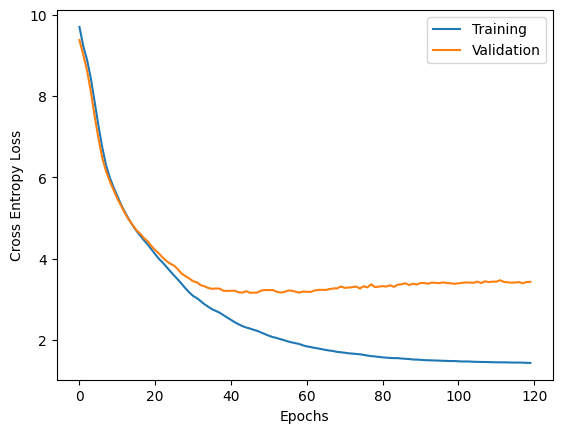

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

s = (len(training_losses_to_plot) // len(val_losses_to_plot)) 

# plt.plot(np.arange(0, len(training_losses_to_plot), 10), training_losses_to_plot[::10])
plt.plot(range(NUM_EPOCHS), training_losses_to_plot, label='Training')
plt.plot(range(NUM_EPOCHS), val_losses_to_plot, label='Validation')
plt.legend()
plt.ylabel("Cross Entropy Loss")
plt.xlabel("Epochs")
plt.show()

#### testing

In [ ]:
from torchmetrics.functional import bleu_score

# function to generate output sequence using greedy algorithm
def greedy_decode(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)

    memory = model.encode(src, src_mask)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        out = model.decode(ys, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# function to generate output sequence using greedy algorithm
def greedy_decode_MNet(model, src, src_mask, max_len, start_symbol):
    src = src.to(DEVICE)
    src_mask = src_mask.to(DEVICE)
    # print(src.shape)
    src_emb = model.positional_encoding(model.src_tok_emb(src))
    # print(src_emb.shape)
    memory = model.transformer.custom_encode(src_emb, src_mask, None)
    ys = torch.ones(1, 1).fill_(start_symbol).type(torch.long).to(DEVICE)
    for i in range(max_len-1):
        memory = memory.to(DEVICE)
        tgt_mask = (generate_square_subsequent_mask(ys.size(0))
                    .type(torch.bool)).to(DEVICE)
        ys_emb = model.positional_encoding(model.tgt_tok_emb(ys))
        out = model.transformer.model.decoder(ys_emb, memory, tgt_mask)
        out = out.transpose(0, 1)
        prob = model.generator(out[:, -1])
        _, next_word = torch.max(prob, dim=1)
        next_word = next_word.item()

        ys = torch.cat([ys,
                        torch.ones(1, 1).type_as(src.data).fill_(next_word)], dim=0)
        if next_word == EOS_IDX:
            break
    return ys


# actual function to translate input sentence into target language
def translate(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

# actual function to translate input sentence into target language
def translate_MNet(model: torch.nn.Module, src_sentence: str):
    model.eval()
    src = text_transform[SRC_LANGUAGE](src_sentence).view(-1, 1)
    # print('in translate, ', src.shape)
    num_tokens = src.shape[0]
    src_mask = (torch.zeros(num_tokens, num_tokens)).type(torch.bool)
    tgt_tokens = greedy_decode_MNet(
        model,  src, src_mask, max_len=num_tokens + 5, start_symbol=BOS_IDX).flatten()
    return " ".join(vocab_transform[TGT_LANGUAGE].lookup_tokens(list(tgt_tokens.cpu().numpy()))).replace("<bos>", "").replace("<eos>", "")

def test(model,):
    test_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
    
    # compute the avg bleu score
    bleu = 0
    ct = 0
    for data_sample in test_iter:
        ct += 1
        # print(data_sample)
        src = data_sample[0]
        tgt = data_sample[1]
        pred = translate(model, src)
        bleu += bleu_score([pred], [tgt])
    return bleu / ct


#### results

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
references = [['this', 'is' 'test']]
candidates = [['this', 'is', 'a', 'test']]
score = corpus_bleu(references, candidates)
print(score)

0


In [ ]:
# transformer.load_state_dict(torch.load('seq2seq_transformer_multi30k_weights_epochs=21.pt'))
from nltk.translate.bleu_score import corpus_bleu, sentence_bleu
test_iter = Multi30k(split='valid', language_pair=(SRC_LANGUAGE, TGT_LANGUAGE))
de = []
en = []
de_preds = []
sentence_scores = []
for data_sample in test_iter:
    if len(data_sample[0]) < 3 or len(data_sample[1]) < 3:
        print('here')
        continue
    
    en.append(data_sample[0].split())
    de.append(data_sample[1].split())
    
    pred = translate(transformer, data_sample[0])
    pred_split = pred.split()
    # if pred_split[-1] == '.':
    #     pred_split = pred_split[:-1] # trim periods
    de_preds.append(pred_split)
    sentence_scores.append(sentence_bleu(de[-1], pred_split))



# score = sentence_bleu(de, de_preds) # compare true de with pred de
# score

/home/kyle/pythonenvs/venv38/lib/python3.10/site-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


here


In [ ]:
print('avg BLEU EN->DE scores: ')

print(sum(sentence_scores) / len(sentence_scores))

avg BLEU EN->DE scores: 
0.30497300137458444


In [ ]:
print(de[0:5])
print(de_preds[0:5])

[['Eine', 'Gruppe', 'von', 'Männern', 'lädt', 'Baumwolle', 'auf', 'einen', 'Lastwagen'], ['Ein', 'Mann', 'schläft', 'in', 'einem', 'grünen', 'Raum', 'auf', 'einem', 'Sofa.'], ['Ein', 'Junge', 'mit', 'Kopfhörern', 'sitzt', 'auf', 'den', 'Schultern', 'einer', 'Frau.'], ['Zwei', 'Männer', 'bauen', 'eine', 'blaue', 'Eisfischerhütte', 'auf', 'einem', 'zugefrorenen', 'See', 'auf'], ['Ein', 'Mann', 'mit', 'beginnender', 'Glatze,', 'der', 'eine', 'rote', 'Rettungsweste', 'trägt,', 'sitzt', 'in', 'einem', 'kleinen', 'Boot.']]
[['Eine', 'Gruppe', 'Männer', 'ist', 'Zuckerwatte', 'versammelt', 'sich', 'der', 'sich', 'um', 'einen', 'Lkw', 'bewegt', '.'], ['Ein', 'schlafender', 'Mann', 'in', 'einem', 'grünen', 'Raum', 'auf', 'einem', 'Sofa', '.'], ['Ein', 'Junge', 'mit', 'Kopfhörer', 'sitzt', 'auf', 'den', 'Schultern', 'einer', 'Frau', '.'], ['Zwei', 'Männer', 'bauen', 'einen', 'blauen', 'Tanz', 'auf', 'einem', 'Eistee', 'über', 'ein', 'See', 'über', 'einen', 'See', '.'], ['Ein', 'kahl', 'werdender'

In [ ]:
# test(transformer)

#### extra

In [ ]:
print(translate(transformer, "Eine Gruppe von Menschen steht vor einem Iglu ."))
print(translate(transformer, "Wie gehen Sie?"))
print(translate(transformer, "Ich heisse Hermann"))

 Hinter einem Gehsteig fahren eine genaue Aufzählung von allem , was ich hier kommen .
 Karatekurs ist bereit zu Besuch . 
 Städtische Baumarbeiter sind in dem Kopf aufgehängt . 


In [ ]:

# A group of people stand in front of an auditorium
# candidate_corpus = [['A', 'group', 'of', 'people', 'stand', 'in', 'front', 'of', 'an', 'auditorium'], ['Wie', 'gehen', 'Sie']]
candidate_corpus = ['A group of people stand in front of an auditorium']
# references_corpus = [['A', 'group', 'of', 'people', 'stand', 'in', 'front', 'of', 'an', 'igloo'], ['How', 'are', 'you'], ['No', 'Match']]
references_corpus = [['A group of people stand in front of an igloo']]
score = bleu_score(candidate_corpus, references_corpus)
print(f'BLEU score for ref_corpus: {references_corpus}, score: {score}')

BLEU score for ref_corpus: [['A group of people stand in front of an igloo']], score: 0.8801117539405823
